In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import alias

In [5]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
qry = session.query(Measurement).first()
qry.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x187ddfbc9b0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()
max_date = list(np.ravel(max_date))[0]
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
max_day = int(dt.datetime.strftime(max_date, '%d'))
max_month = int(dt.datetime.strftime(max_date, '%m'))
max_year = int(dt.datetime.strftime(max_date, '%Y'))
year_early = dt.date(max_year, max_month, max_day) - dt.timedelta(days=365)
year_early

datetime.date(2016, 8, 23)

Text(0, 0.5, 'Precipitation (inches)')

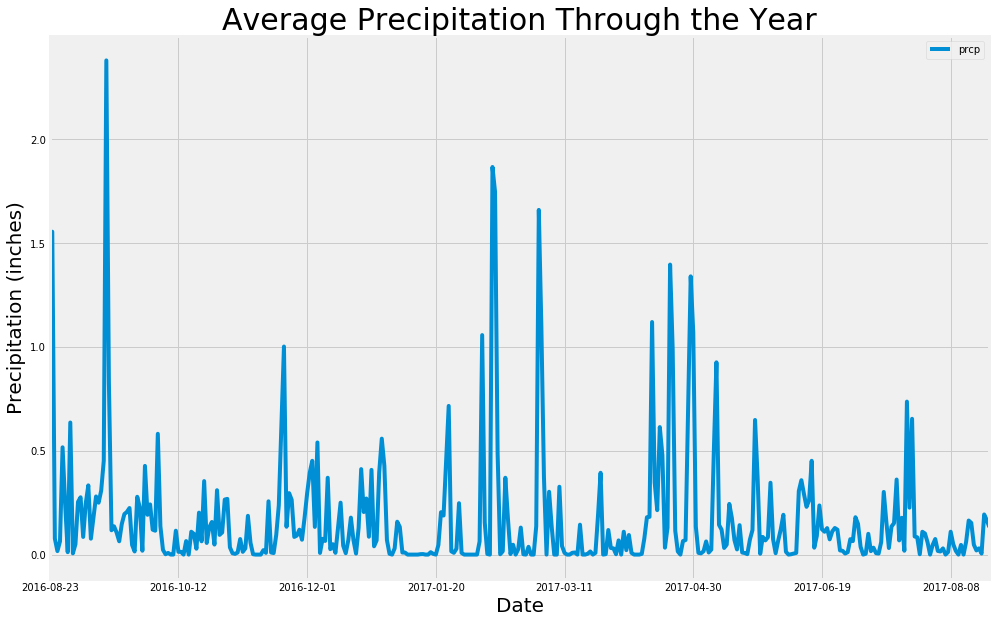

In [12]:
# Perform a query to retrieve the data and precipitation scores
current_annual_prcp = session.query(Measurement.date, Measurement.prcp).filter(func.date(Measurement.date) >= year_early).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_rough = pd.DataFrame(current_annual_prcp)
# Sort the dataframe by date
prcp_df = prcp_rough.groupby(prcp_rough.date).mean()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(15,10))
plt.title('Average Precipitation Through the Year', size=30)
plt.xlabel('Date', size=20)
plt.ylabel('Precipitation (inches)', size=20)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.distinct(Measurement.station)).count()
stations_count

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).first()
temp_data

(53.0, 87.0, 73.09795396419437)

Text(0.5, 1.0, 'Temperature for the Year')

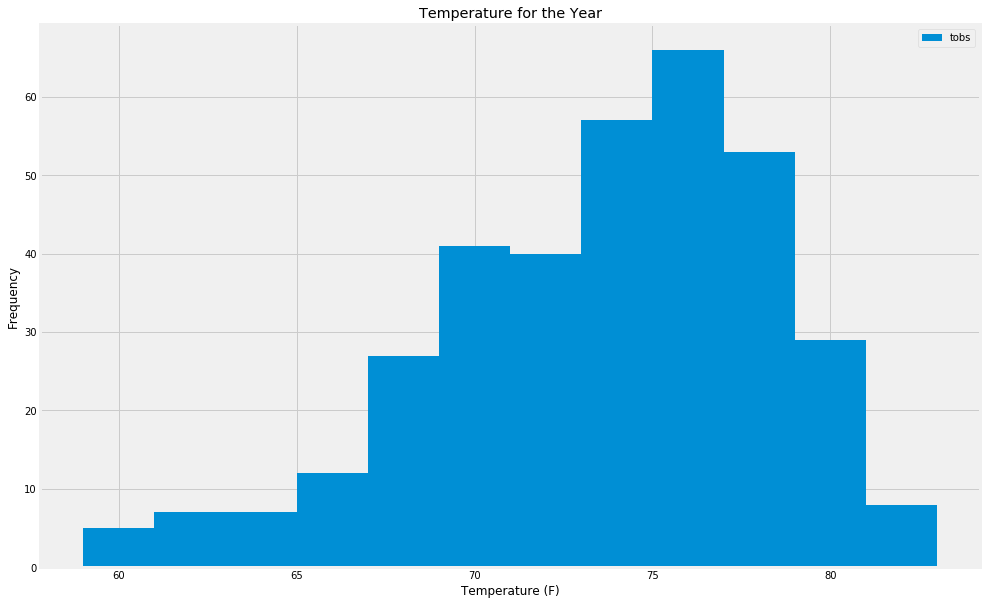

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year_q = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').filter(func.date(Measurement.date) >= '2016-08-23').all()
temp_year_p = pd.DataFrame(temp_year_q)
temp_year = temp_year_p.groupby(temp_year_p.date).mean()
temp_year.plot.hist(bins=12, figsize=(15,10))
plt.xlabel('Temperature (F)')
plt.title('Temperature for the Year')

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_year = calc_temps('2016-08-23','2017-08-23')
calc_year = calc_year[0]
calc_year

(58.0, 74.59058295964125, 87.0)

Text(0, 0.5, 'Temperature')

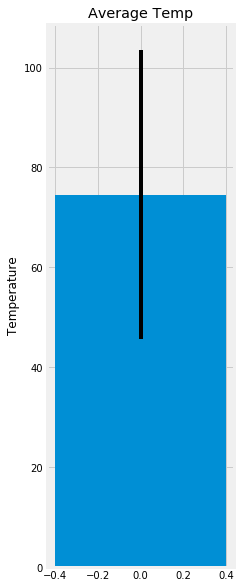

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,10))
ax.bar(0, calc_year[1], yerr=(calc_year[2]-calc_year[0]))
plt.title('Average Temp')
plt.ylabel('Temperature')

In [21]:
qry2 = session.query(Station).first()
qry2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x187de2a0b00>,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).join(Measurement, Measurement.station==Station.station).group_by(Station.station).order_by(Measurement.prcp).all()
total_rain

[('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  None),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, None),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  None),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  None),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, None),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  None),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.0)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
l = []
dates = []
normals = []
# Set the start and end date of the trip
s = '2019-12-25'
e = '2019-12-30'
# Use the start and end date to create a range of dates
start = dt.datetime.strptime(s, '%Y-%m-%d')
end = dt.datetime.strptime(e, '%Y-%m-%d')
# Stip off the year and save a list of %m-%d strings
step = dt.timedelta(days=1)
while start <= end:
    l.append(start.date())
    start += step
for x in l:
    dates.append(dt.datetime.strftime(x, '%m-%d'))
# Loop through the list of %m-%d strings and calculate the normals for each date
for x in dates:
    q = daily_normals(x)
    normals.append(q[0])
normals

[(60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfp = pd.DataFrame.from_records(normals, columns=['tmin', 'tavg', 'tmax'])
dfp['trip_dates'] = dates 
df = dfp.set_index('trip_dates')
df

,tmin,tavg,tmax
trip_dates,,,
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0
12-30,63.0,69.863636,76.0


Text(0.5, 1.0, 'Temperature on Trip Dates')

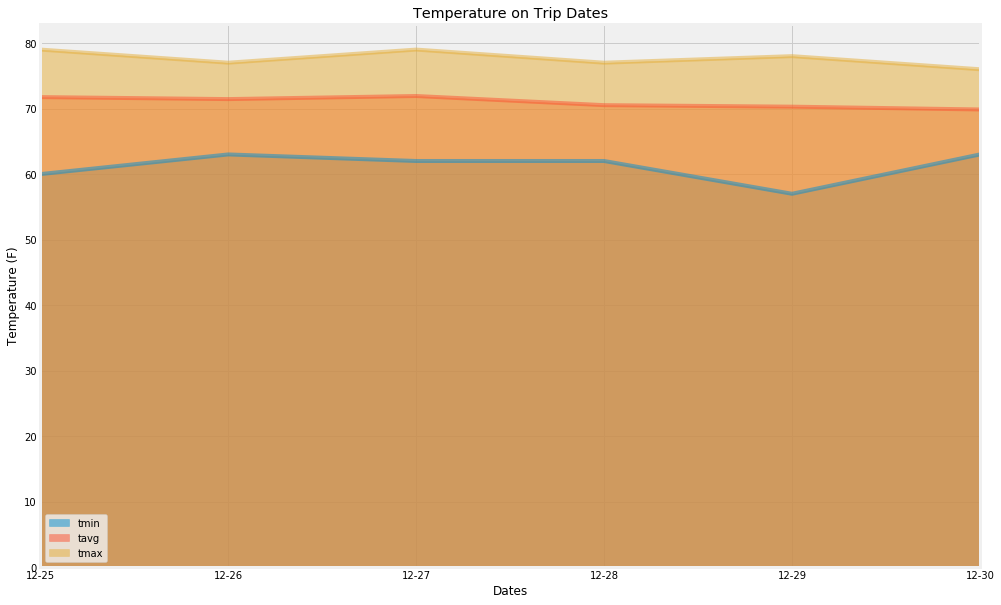

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(figsize=(15,10), stacked=False)
plt.ylim=100
plt.xlabel("Dates")
plt.ylabel("Temperature (F)")
plt.title("Temperature on Trip Dates")